<a href="https://colab.research.google.com/github/inesbsilveira/2nd-semester-2023/blob/main/20230913_workinprogress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 33.8 MB/s eta 0:00:00


In [2]:
import rasterio
from rasterio.windows import Window
import os
import shutil
import numpy as np
from PIL import Image

from fastai.vision.all import *
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [70]:
user='I' # escolher 'M' ou 'I'
N_epochs=20
target_names = ['not greenhouse', 'greenhouse']
Nrows,Ncols = 20, 8 # número de blocos a usar 20*8=160

In [5]:
# Specify the directory path
if user=='M':
  directory = '/content/drive/MyDrive/inv_proj/S2change_DGT/Estufas_Alentejo'
else:
  directory = '/content/drive/MyDrive/AAA/'

image_folder_name = "images"
label_folder_name = "labels"
predicted_folder_name = "predicted"
image_folder = os.path.join(directory, image_folder_name)
label_folder = os.path.join(directory, label_folder_name)
predicted_folder = os.path.join(directory, predicted_folder_name)

training_set_file_name = "training_set.txt"
test_set_file_name = "test_set.txt"

Functions

In [6]:
def clip_raster_to_subrasters(input_file, output_folder, Nrows, Ncols):
    with rasterio.open(input_file) as src:
        height = src.height // Nrows
        width = src.width // Ncols

        for i in range(Nrows):
            for j in range(Ncols):
                ymin = i * height
                ymax = (i + 1) * height
                xmin = j * width
                xmax = (j + 1) * width
                window = Window.from_slices((ymin, ymax), (xmin, xmax))

                clipped_data = src.read(window=window)
                clipped_meta = src.meta.copy()
                clipped_meta.update({
                    'height': window.height,
                    'width': window.width,
                    'transform': src.window_transform(window)
                })

                output_file = os.path.join(output_folder, f'image_{i}_{j}_mask.png')
                with rasterio.open(output_file, 'w', **clipped_meta) as dst:
                    dst.write(clipped_data)


In [7]:
def rescale_to_8bits(arr):
    arr_std = (arr - np.min(arr)) / (np.max(arr) - np.min(arr)) * 255
    arr_std = arr_std.astype(np.uint8)
    return arr_std

In [8]:
def clip_and_rescale_to_8bits(input_file, output_folder, Nrows, Ncols):
    with rasterio.open(input_file) as src:
        height = src.height // Nrows
        width = src.width // Ncols

        for i in range(Nrows):
            for j in range(Ncols):
                ymin = i * height
                ymax = (i + 1) * height
                xmin = j * width
                xmax = (j + 1) * width
                window = Window.from_slices((ymin, ymax), (xmin, xmax))

                clipped_data_1 = rescale_to_8bits(src.read(1, window=window))
                clipped_data_2 = rescale_to_8bits(src.read(2, window=window))
                clipped_data_3 = rescale_to_8bits(src.read(3, window=window))

                rgb_image = np.stack([clipped_data_1, clipped_data_2, clipped_data_3], axis=2)

                image = Image.fromarray(rgb_image, mode='RGB')
                output_file = os.path.join(output_folder, f'image_{i}_{j}.png')
                image.save(output_file)


In [9]:
# Define the function to extract the row and column number from the test image file name
def get_row_column_from_filename(filename):
    filename = os.path.basename(filename)
    parts = filename.split('_')
    row = int(parts[1])
    column = int(parts[2].split('.')[0])
    return row, column

In [10]:
# Create DataBlock
def get_items(path):
    image_files = get_image_files(image_folder)
    return image_files

def get_mask_fn(image_file):
    return mask_folder / f'{image_file.stem}_mask.png'

Main Execution

In [11]:
# Clip and rescale label images
clip_raster_to_subrasters(os.path.join(directory, 'mask_3763_reclass.tif'), label_folder, Nrows, Ncols)

# Clip and rescale image bands
clip_and_rescale_to_8bits(os.path.join(directory, '3bands_clipped_tif.tif'), image_folder, Nrows, Ncols)


In [12]:
path=Path(directory)
image_folder = path/'images'
mask_folder = path/'labels'

# Create DataBlock
items = get_items(path)
dblock = DataBlock(blocks=(ImageBlock, MaskBlock(target_names)),
                   get_items=get_items,
                   get_y=get_mask_fn,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42))

# Create DataLoaders
dls = dblock.dataloaders(path, bs=8)

In [13]:
# Create a stratified split of the indices for training and test set
train_idx, test_idx = RandomSplitter(valid_pct=0.2, seed=42)(items)
train_items = [items[i] for i in train_idx]
test_items = [items[i] for i in test_idx]

# Write the training set items to a txt file
training_set_file = path / 'training_set.txt'
with open(training_set_file, 'w') as f:
    for item in train_items:
        f.write(str(item) + '\n')

# Write the test set items to a txt file
test_set_file = path / 'test_set.txt'
with open(test_set_file, 'w') as f:
    for item in test_items:
        f.write(str(item) + '\n')

print("Paths of training and test sets have been stored in 'training_set.txt' and 'test_set.txt' respectively.")

Paths of training and test sets have been stored in 'training_set.txt' and 'test_set.txt' respectively.


In [71]:
# Define U-Net model
learn = unet_learner(dls, resnet34)

# Train the model
# In the following line of code, adjust the number of epochs to see different results
learn.fine_tune(N_epochs)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,time
0,0.557367,0.341921,00:52


epoch,train_loss,valid_loss,time
0,0.333648,0.294922,00:50
1,0.317693,0.311216,00:50
2,0.305911,0.300047,00:54
3,0.289817,0.318444,00:50
4,0.281738,0.343251,00:50
5,0.315612,0.437215,00:51
6,0.316756,0.326571,00:49
7,0.296939,1.262078,00:51
8,0.330208,0.319657,00:49
9,0.316287,0.302167,00:50


epoch,train_loss,valid_loss,time
0,0.333648,0.294922,00:50
1,0.317693,0.311216,00:50
2,0.305911,0.300047,00:54
3,0.289817,0.318444,00:50
4,0.281738,0.343251,00:50
5,0.315612,0.437215,00:51
6,0.316756,0.326571,00:49
7,0.296939,1.262078,00:51
8,0.330208,0.319657,00:49
9,0.316287,0.302167,00:50


torch.Size([160, 2, 58, 57]) None


<Axes: >

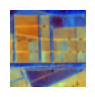

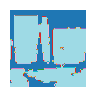

In [72]:
# Perform inference on test images
test_dl = dls.test_dl(get_image_files(image_folder)) # usa todas as 160 imagens em image_folder, treino e validação
preds = learn.get_preds(dl=test_dl)
print(preds[0].shape, preds[1])

# Display sample predictions
sample_idx = 0
sample_image_path = list(test_dl.items)[sample_idx]
sample_image = PILImage.create(sample_image_path)
sample_pred = preds[0][sample_idx].argmax(dim=0).numpy()

sample_image.show()
TensorImage(sample_pred).show(cmap='tab20')

In [73]:
# Save the predicted mask images according to their row and column number
# Define paths to the "predicted" folders
#predicted_folder = Path('/content/drive/MyDrive/AAA/predicted')
predicted_folder = os.path.join(directory, predicted_folder_name)

preds = learn.get_preds(dl=test_dl)[0]
for idx, pred in enumerate(preds):
    # Get the row and column number from the test image file name
    sample_image_path = list(test_dl.items)[idx]
    row, column = get_row_column_from_filename(sample_image_path)

    # Create a folder for each row if it doesn't exist
    row_folder = os.path.join(predicted_folder, f'row_{row}')
    os.makedirs(row_folder, exist_ok=True)

    # Create a filename for the predicted mask image
    predicted_filename = f'image_{row}_{column}_predicted.png'
    predicted_filepath = os.path.join(row_folder, predicted_filename)

    # Convert the predicted mask to a PIL Image
    sample_pred = pred.argmax(dim=0).numpy()
    predicted_image = Image.fromarray((sample_pred * 255).astype(np.uint8))

    # Save the predicted mask image
    predicted_image.save(predicted_filepath)

In [74]:
with rasterio.open(os.path.join(directory,'mask_3763_reclass.tif')) as src:
    # Calculate the height and width of the sub-rasters
    height = src.height // Nrows  # Divide the raster into 4 rows
    width = src.width // Ncols  # Divide the raster into 8 columns

In [75]:
# Merge all predicted mask images according to their row and column
rows, columns = Nrows,Ncols # 20, 8  # Number of rows and columns in the grid
merged_width = width * columns
merged_height = height * rows
merged_image = Image.new('RGB', (merged_width, merged_height))

# Loop through each row and column to merge the images
for i in range(rows):
    for j in range(columns):
        # Load the predicted mask image
        predicted_file = os.path.join(predicted_folder, f'row_{i}', f'image_{i}_{j}_predicted.png')
        predicted_image = Image.open(predicted_file)

        # Define the position to paste the mask image in the merged image
        x_offset = j * width
        y_offset = i * height

        # Paste the mask image in the merged image
        merged_image.paste(predicted_image, (x_offset, y_offset))

# Save the merged image
merged_output_file = os.path.join(predicted_folder, 'merged_predicted_masks_20_1309.png')
merged_image.save(merged_output_file)


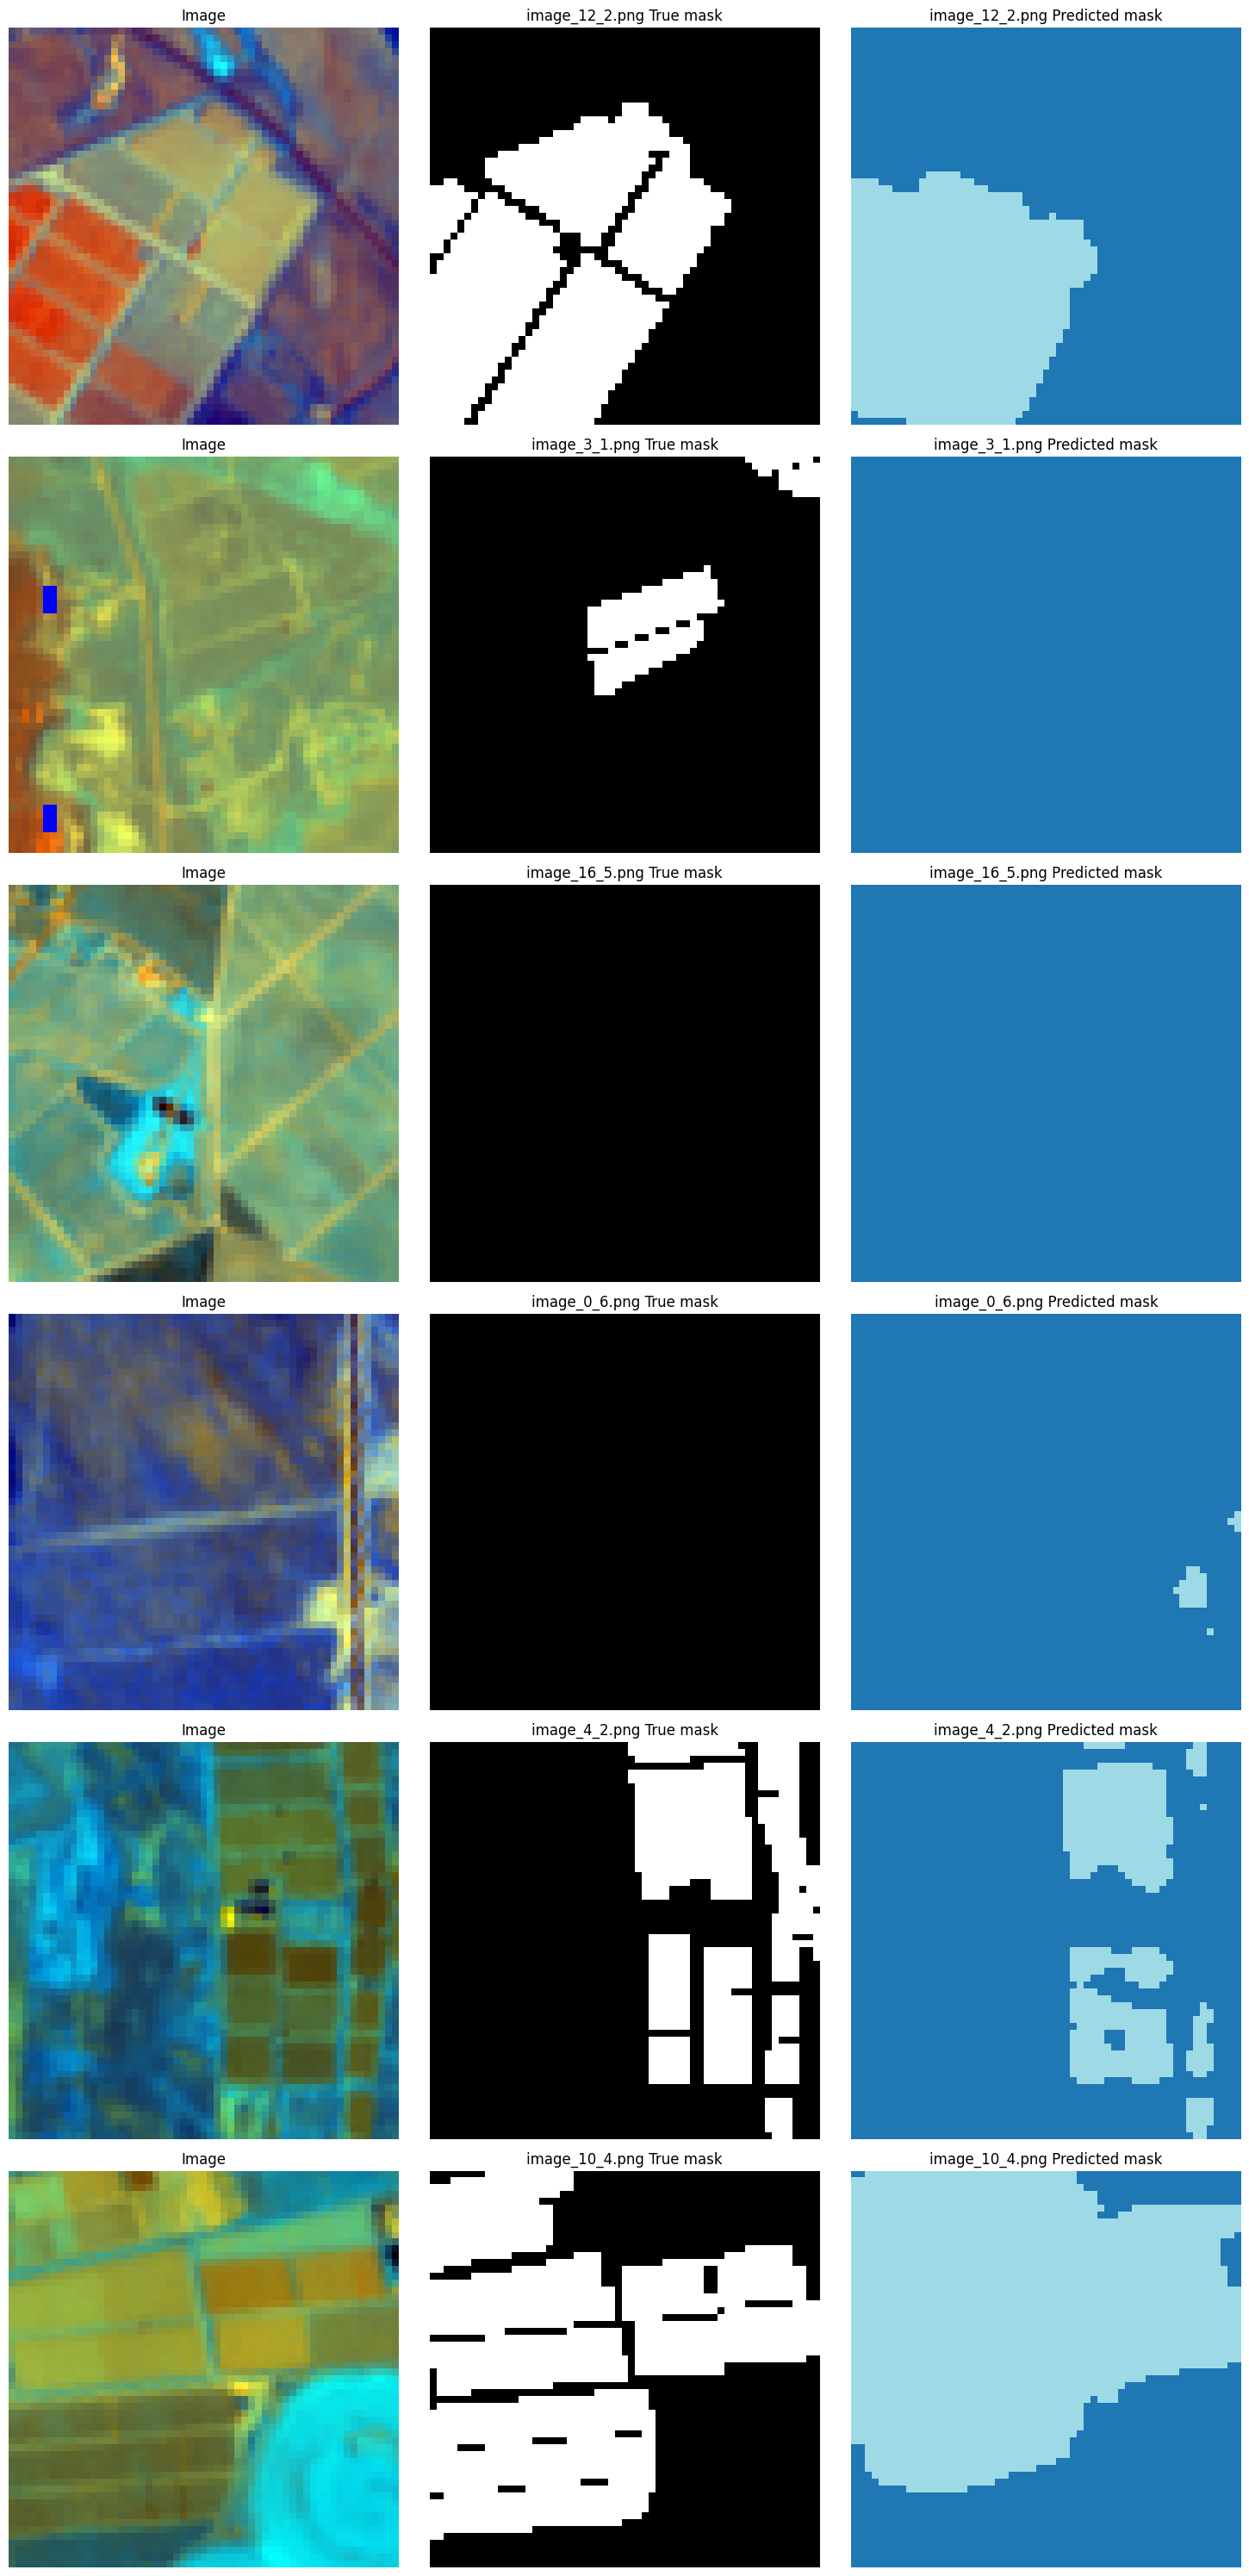

In [76]:
# Define paths to the "predicted" folders
#predicted_folder = Path('/content/drive/MyDrive/AAA/predicted')
predicted_folder = os.path.join(directory, predicted_folder_name)

# Get the file names of the test set images
with open('/content/drive/MyDrive/AAA/test_set.txt', 'r') as f:
    test_set_files = [line.strip() for line in f]

# Display sample predictions using file names of test_set
sample_files = [Path(file_path).name for file_path in test_set_files]

# Slice the sample_files list to include only the first 6 samples
sample_files = sample_files[:6]

# Define the number of columns (including both true and predicted masks)
num_columns = 3

fig, axes = plt.subplots(len(sample_files), num_columns, figsize=(15, 5 * len(sample_files)))

for i, file_name in enumerate(sample_files):
    sample_image_path = image_folder / file_name
    sample_image = PILImage.create(sample_image_path)
    sample_pred = preds[i].argmax(dim=0).numpy()

    # Load the ground truth mask for the sample from the "labels" folder
    row, column = get_row_column_from_filename(file_name)
    mask_file = mask_folder / f'image_{row}_{column}_mask.png'
    true_mask = np.array(Image.open(mask_file))

    # Load the predicted mask for the sample from the "predicted" folder
    predicted_file = os.path.join(predicted_folder, f'row_{row}', f'image_{row}_{column}_predicted.png')
    pred_mask = np.array(Image.open(predicted_file))

    # image of satellite aggregate
    axes[i, 0].imshow(sample_image)
    axes[i, 0].set_title('Image')
    axes[i, 0].axis('off')

    # image of true mask
    axes[i, 1].imshow(true_mask, cmap='gray')
    axes[i, 1].set_title(file_name + " True mask")
    axes[i, 1].axis('off')

    # image of predicted mask
    axes[i, 2].imshow(pred_mask, cmap='tab20')
    axes[i, 2].set_title(file_name + " Predicted mask")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


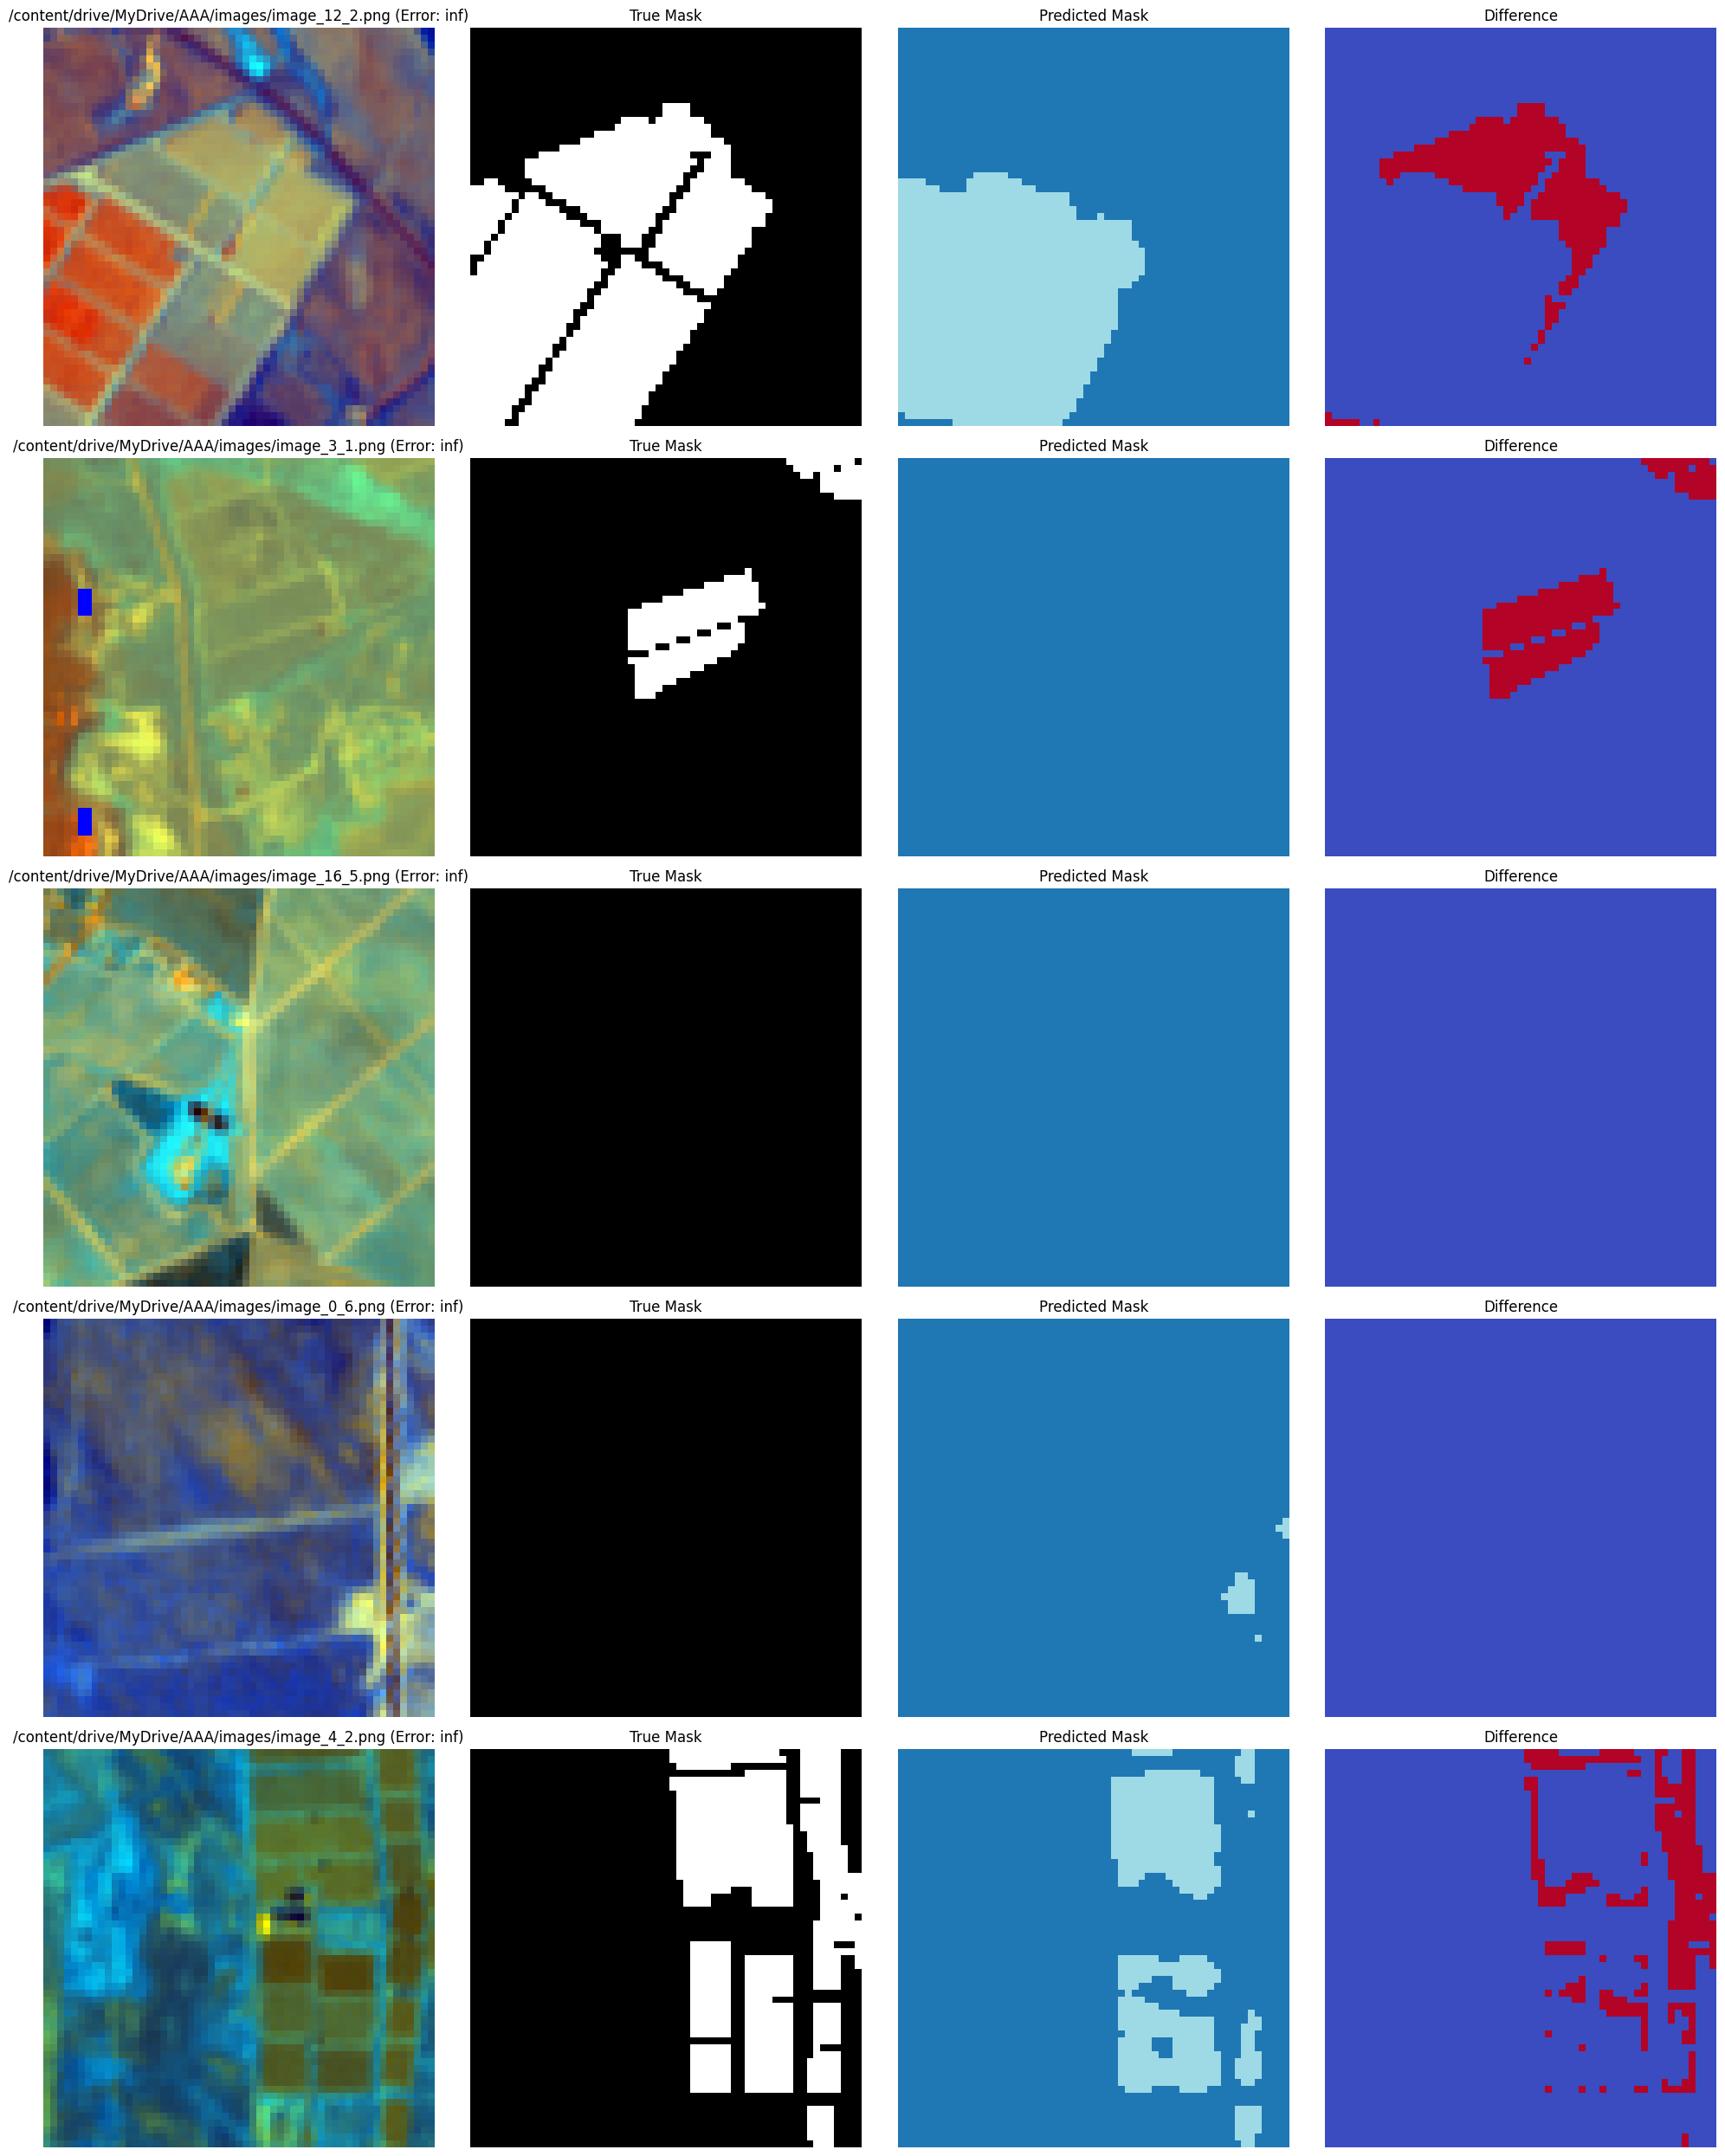

In [77]:
# Calculate pixel-wise errors and store them in a dictionary
errors = {}

for file_name in test_set_files:
    # Load the ground truth mask for the sample from the "labels1" folder
    row, column = get_row_column_from_filename(file_name)
    mask_file = mask_folder / f'image_{row}_{column}_mask.png'
    true_mask = np.array(Image.open(mask_file))

    # Load the predicted mask for the sample from the "predicted" folder
    predicted_file = os.path.join(predicted_folder, f'row_{row}', f'image_{row}_{column}_predicted.png')
    pred_mask = np.array(Image.open(predicted_file))

    # Calculate the pixel-wise error between the true mask and predicted mask
    error = np.sum(np.abs(true_mask - pred_mask))
    errors[file_name] = error

# Sort the blocks by error in descending order
sorted_errors = {k: v for k, v in sorted(errors.items(), key=lambda item: item[1], reverse=True)}

# Get the file names of the blocks with the highest errors
top_5_blocks = list(sorted_errors.keys())[:5]

# Display the top 5 blocks with the highest errors
num_columns = 4

fig, axes = plt.subplots(len(top_5_blocks), num_columns, figsize=(20, 5 * len(top_5_blocks)))

for i, file_name in enumerate(top_5_blocks):
    sample_image_path = image_folder / file_name
    sample_image = PILImage.create(sample_image_path)

    # Load the ground truth mask for the sample from the "labels1" folder
    row, column = get_row_column_from_filename(file_name)
    mask_file = mask_folder / f'image_{row}_{column}_mask.png'
    true_mask = np.array(Image.open(mask_file))

    # Load the predicted mask for the sample from the "predicted" folder
    predicted_file = os.path.join(predicted_folder, f'row_{row}', f'image_{row}_{column}_predicted.png')
    pred_mask = np.array(Image.open(predicted_file))

    # Display the satellite aggregate image with file name as title
    axes[i, 0].imshow(sample_image)
    axes[i, 0].set_title(file_name + " (Error: " + str(errors[file_name]) + ")")
    axes[i, 0].axis('off')

    # Display the true mask
    axes[i, 1].imshow(true_mask, cmap='gray')
    axes[i, 1].set_title('True Mask')
    axes[i, 1].axis('off')

    # Display the predicted mask
    axes[i, 2].imshow(pred_mask, cmap='tab20')
    axes[i, 2].set_title('Predicted Mask')
    axes[i, 2].axis('off')

    # Display the difference between true and predicted masks
    difference_mask = true_mask - pred_mask
    axes[i, 3].imshow(difference_mask, cmap='coolwarm', vmin=-1, vmax=1)
    axes[i, 3].set_title('Difference')
    axes[i, 3].axis('off')

plt.tight_layout()
plt.show()

In [78]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Perform inference on the test set
preds, _ = learn.get_preds(dl=dls.valid)

# Convert the predicted masks to a numpy array
predicted_masks = preds.argmax(dim=1).numpy()

# Get the ground truth masks for the test set
true_masks = [y for _, y in dls.valid]

# Convert the list of true masks to a numpy array
true_masks = torch.cat(true_masks).cpu().numpy()

# Flatten the masks to be 1D arrays
true_masks_flat = true_masks.ravel()
predicted_masks_flat = predicted_masks.ravel()

# Calculate the confusion matrix for the test set
conf_matrix = confusion_matrix(true_masks_flat, predicted_masks_flat)

print("Confusion Matrix for the Test Set:")
print(conf_matrix)


Confusion Matrix for the Test Set:
[[92622  2416]
 [ 4515  6239]]


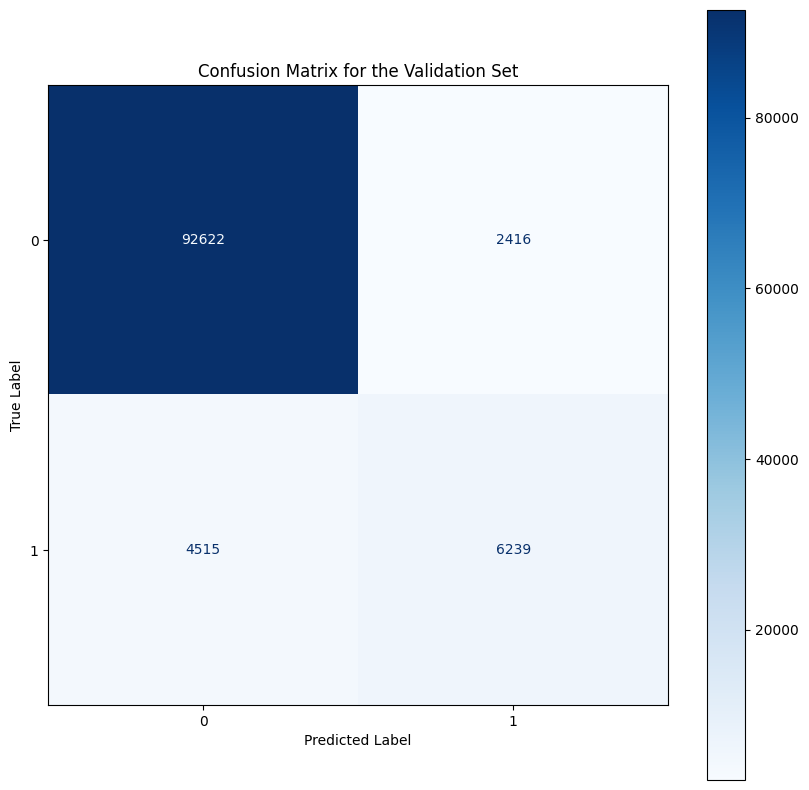

In [79]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues', ax=ax)

# Set the title and axis labels
ax.set_title('Confusion Matrix for the Validation Set')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

# Show the plot
plt.show()

In [80]:
# Calculate the total number of pixels
total_pixels = len(true_masks_flat)

# Calculate the number of correctly predicted pixels (True Positives + True Negatives)
correct_pixels = np.sum(true_masks_flat == predicted_masks_flat)

# Calculate the model accuracy
accuracy = correct_pixels / total_pixels

print("Model Accuracy for the Test Set: {:.2f}%".format(accuracy * 100))

Model Accuracy for the Test Set: 93.45%


In [81]:
# Calculate and print the classification report
report = classification_report(true_masks_flat, predicted_masks_flat, target_names=target_names)
print("\nClassification Report for the Test Set:")
print(report)


Classification Report for the Test Set:
                precision    recall  f1-score   support

not greenhouse       0.95      0.97      0.96     95038
    greenhouse       0.72      0.58      0.64     10754

      accuracy                           0.93    105792
     macro avg       0.84      0.78      0.80    105792
  weighted avg       0.93      0.93      0.93    105792



In [82]:
# Load the ground truth TIFF mask and predicted PNG mask
with rasterio.open(os.path.join(directory, 'mask_3763_reclass.tif')) as tiff_mask:
    ground_truth_mask = tiff_mask.read(1)  # Assuming it's a one-band TIFF

# Load the predicted PNG mask
predicted_mask = Image.open(os.path.join(predicted_folder, 'merged_predicted_masks_20_1309.png'))
# Convert the predicted mask to grayscale
predicted_mask = predicted_mask.convert('L')
# Resize the predicted mask to match the dimensions of the ground truth mask
predicted_mask = predicted_mask.resize(ground_truth_mask.shape[::-1], Image.ANTIALIAS)
# Convert to a NumPy array
predicted_mask = np.array(predicted_mask)

<ipython-input-82-bd857572da4a>:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  predicted_mask = predicted_mask.resize(ground_truth_mask.shape[::-1], Image.ANTIALIAS)


In [83]:
# Create an aligned predicted mask with the same values as the ground truth mask
aligned_predicted_mask = np.array(predicted_mask)

# Identify commission errors (false positives)
commission_errors = (aligned_predicted_mask == 1) & (ground_truth_mask == 0)

# Identify omission errors (false negatives)
omission_errors = (aligned_predicted_mask == 0) & (ground_truth_mask == 1)


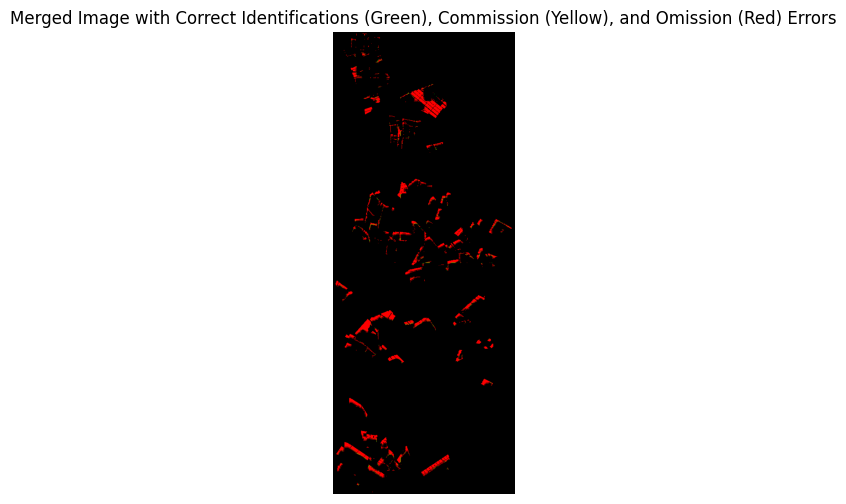

In [88]:
# Create a merged image for visualization
merged_image = np.zeros((ground_truth_mask.shape[0], ground_truth_mask.shape[1], 3), dtype=np.uint8)

# Mark correct identifications in green
correct_identifications = (aligned_predicted_mask == ground_truth_mask)
merged_image[correct_identifications] = [0, 255, 0]  # Green color

# Mark commission errors (false positives) in yellow
merged_image[commission_errors] = [255, 255, 0]  # Yellow color

# Mark omission errors (false negatives) in red
merged_image[omission_errors] = [255, 0, 0]  # Red color

# Display the merged image
plt.figure(figsize=(8, 6))
plt.imshow(merged_image)
plt.axis('off')
plt.title('Merged Image with Correct Identifications (Green), Commission (Yellow), and Omission (Red) Errors')
plt.show()

# Save the merged image
merged_output_file = os.path.join(predicted_folder, 'comission_omission.png')
plt.imsave(merged_output_file, merged_image)